### Initialise

In [78]:
d = '/Users/ezatterin/Documents/UCL_phd/data/XRD/'
%cd '/Users/ezatterin/Documents/UCL_phd/scripts/python/edo_xrd/'

/Users/ezatterin/Documents/UCL_phd/scripts/python/edo_xrd


In [79]:
import numpy as np
import matplotlib.pyplot as plt
import utils as ut
from more_utils import calc_ctr, find_osc, l_prof_max
from ipywidgets import interact, FloatSlider, IntSlider, ToggleButtons, RadioButtons, fixed
from scipy.signal import savgol_filter
from scipy.optimize import leastsq
import peakutils as pk

In [80]:
%matplotlib inline
%config InlineBackend.figure_formats = set(['retina'])

### Model

The Lorentzian PSF is defined as follows:

$$ L(q_x) = H \dfrac{w^2}{w^2 + (q_x - q_{x_0})^2} $$

where:
- $H$ =  peak height (amplitude)
- $w$ = FWHM ($0.5 H$)
- $q_x$ = the data
- $q_{x_0}$ = the peak centre

I define a function that computes the sum of two Lorentzians with two different set of parameters.

In [81]:
def lor_sum(x,p1,p2):
    y1 = p1[2]*(p1[0]**2/((x-p1[1])**2 + p1[0]**2))
    y2 = p2[2]*(p2[0]**2/((x-p2[1])**2 + p2[0]**2))
    return y1 + y2

And then a function that computes the residuals between model and data, like so:

$$ R(q_x) = I_{obs} - I_{calc} = I_{obs} - L(q_x) $$

In [82]:
def res(p1,p2,y,x):
    err = y - lor_sum(x,p1,p2)
    return err

### Data

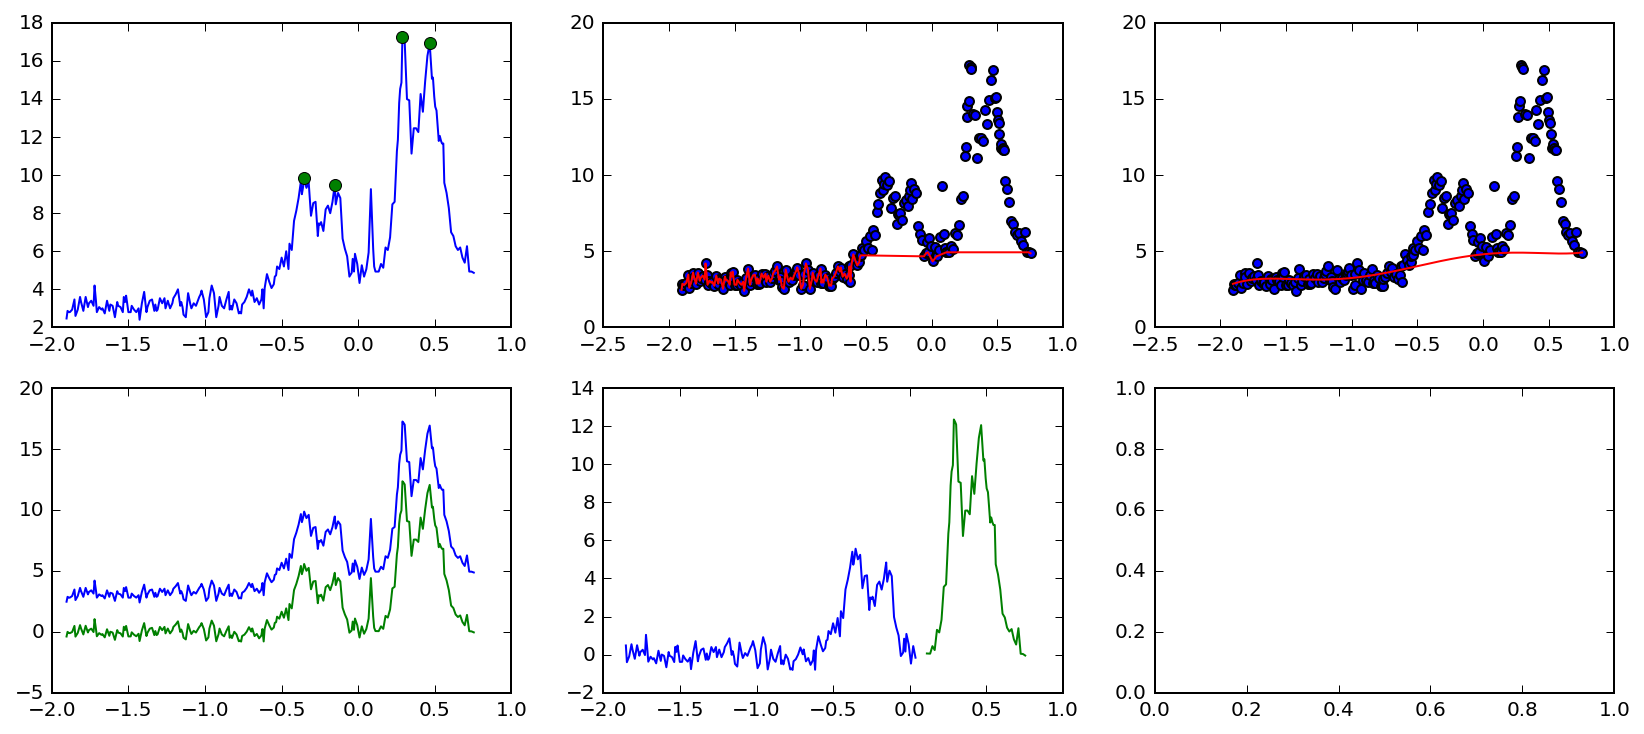

In [109]:
# load the data
Q, I = l_prof_max('e16018',d,'103',L=3.05122,q=True)

# find the peaks
idxs = pk.indexes(I, thres=0.6, min_dist=10)
peaks = I[idxs].argsort()[::1][1:]
xpeak, ypeak = Q[idxs][peaks], I[idxs][peaks]

# select the background
xbg = Q[I<5]
ybg = I[I<5]

# fit and subtract the background
pfit = np.polyfit(xbg, ybg, 5)
bg = np.polyval(pfit, Q)
i_corr = I - bg

# select regions of interest
dist = 0.2
dist2 = 0.36
bg_dist = 1.5
# first set of peaks
idx_1 = (Q > xpeak[0] - dist - bg_dist) & (Q < xpeak[0] + dist)
q1, i1 = Q[idx_1], i_corr[idx_1]
# second set of peaks
idx_2 = (Q > xpeak[2] - dist2) & (Q < xpeak[2] + dist2 + bg_dist)
q2, i2 = Q[idx_2], i_corr[idx_2]

# plotting
fig, ax = plt.subplots(2,3,figsize=(14,6))
ax[0,0].plot(Q, I)
ax[0,0].plot(xpeak, ypeak, 'o')
ax[0,1].scatter(Q,I)
ax[0,1].plot(xbg, ybg, 'red')
ax[0,2].scatter(Q,I)
ax[0,2].plot(Q,bg,'red')
ax[1,0].plot(Q,I,Q,i_corr)
ax[1,1].plot(q1,i1,q2,i2)
plt.show()

Select a set of initial parameters to estimate the lorentzians for each set of peaks.
### Set 1

Initial parameteres:

In [99]:
# initial values:
p11 = [0.01,-0.35,4] # fwhm, peak centre, intensity
p12 = [0.01,-0.25,4]

Refine parameters via least-squares using the residuals function:

In [100]:
pbest11 = leastsq(res, p11, args=(p12, i1, q1), full_output=1)
pb11 = pbest11[0]
pbest12 = leastsq(res, p12, args=(pb11, i1, q1), full_output=1)
pb12 = pbest12[0]

Calculate the lorentzians with these parameters and plot it:

The FWHM1 is: 0.111; the FWHM2 is -0.035


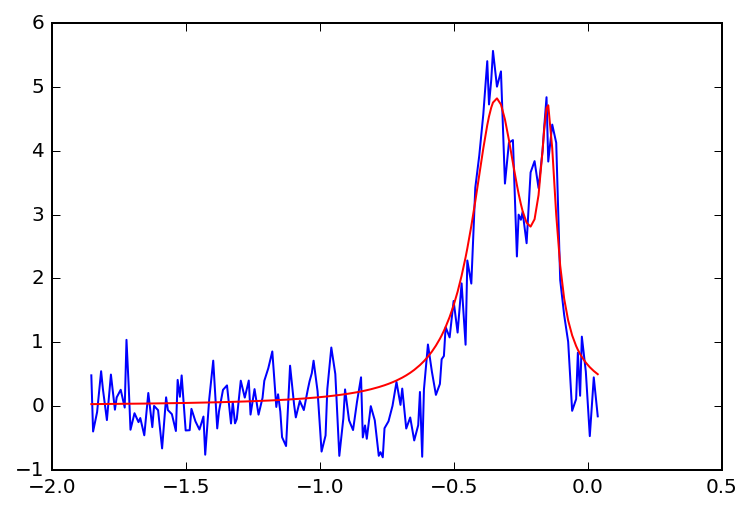

In [101]:
fit1 = lor_sum(q1,pb11,pb12)
plt.plot(q1,i1)
plt.plot(q1,fit1,'red');
print('The FWHM1 is: {0:.3f}; the FWHM2 is {1:.3f}'.format(pb11[0],pb12[0]))

### Set 2

Initial parameteres:

In [103]:
# initial values:
p21 = [0.1,0.29,12] # fwhm, peak centre, intensity
p22 = [0.1,0.47,12]

Refine parameters via least-squares using the residuals function:

In [42]:
pbest21 = leastsq(res, p21, args=(p22, i2, q2), full_output=1)
pb21 = pbest21[0]
pbest22 = leastsq(res, p22, args=(pb21, i2, q2), full_output=1)
pb22 = pbest22[0]

Calculate the lorentzians with these parameters and plot it:

The FWHM1 is: 0.029; the FWHM2 is 0.093


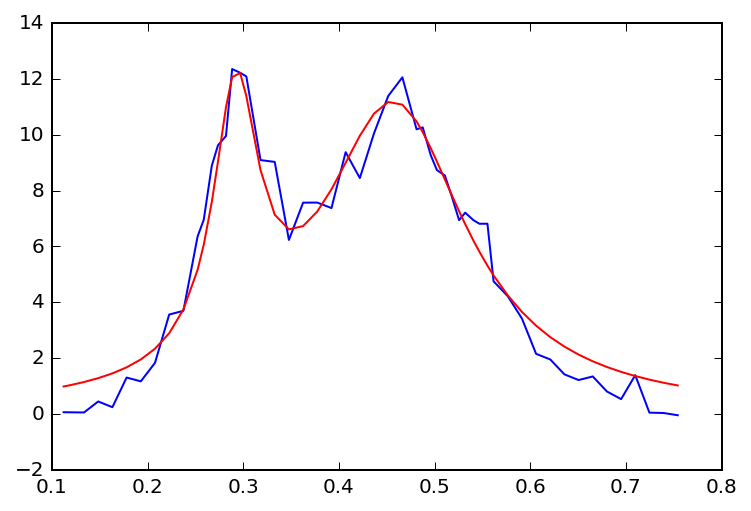

In [43]:
fit2 = lor_sum(q2,pb21,pb22)
plt.plot(q2,i2)
plt.plot(q2,fit2,'red');
print('The FWHM1 is: {0:.3f}; the FWHM2 is {1:.3f}'.format(pb21[0],pb22[0]))

### Plot the whole thing:

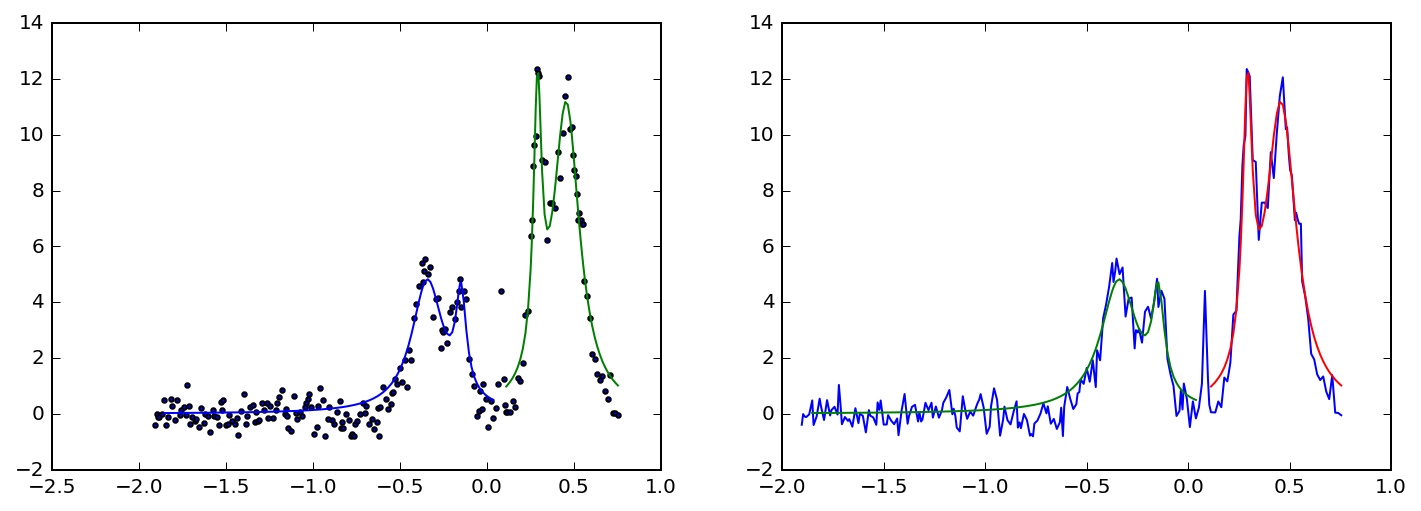

In [44]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(Q,i_corr,marker='.')
ax[0].plot(q1,fit1,q2,fit2)
ax[1].plot(Q,i_corr)
ax[1].plot(q1,fit1,q2,fit2)
plt.show()

In [45]:
print 'The FWHM are:'
print '{0:.3f}, {1:.3f}, {2:.3f}, {3:.3f}'.format(pb11[0], pb12[0], pb21[0], pb22[0])

The FWHM are:
0.111, -0.035, 0.029, 0.093


### Add the FWHM data from the other samples and plot against film thickness

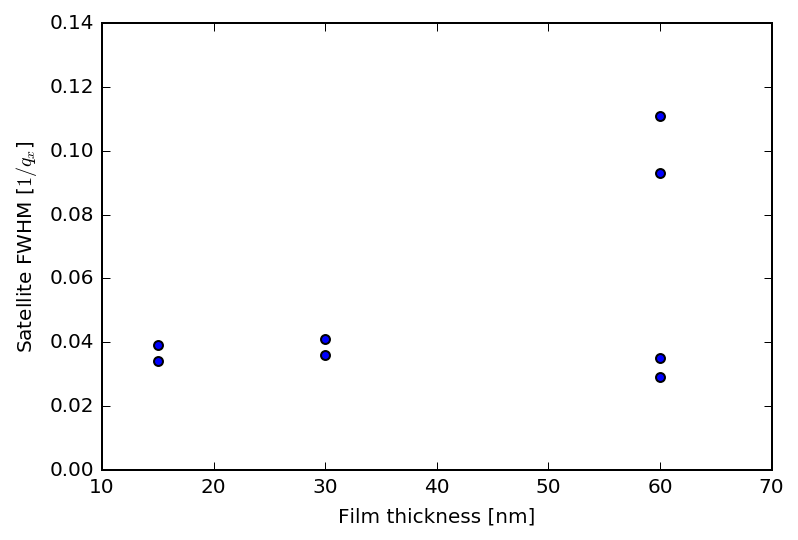

In [46]:
x = [15,15,30,30,60,60,60,60]
y = [0.034,0.039,0.036,0.041,0.111,0.035,0.029,0.093]
plt.scatter(x,y)
plt.xlabel('Film thickness [nm]')
plt.ylabel('Satellite FWHM [$1/q_x$]')

## Try with the 104 peak as well

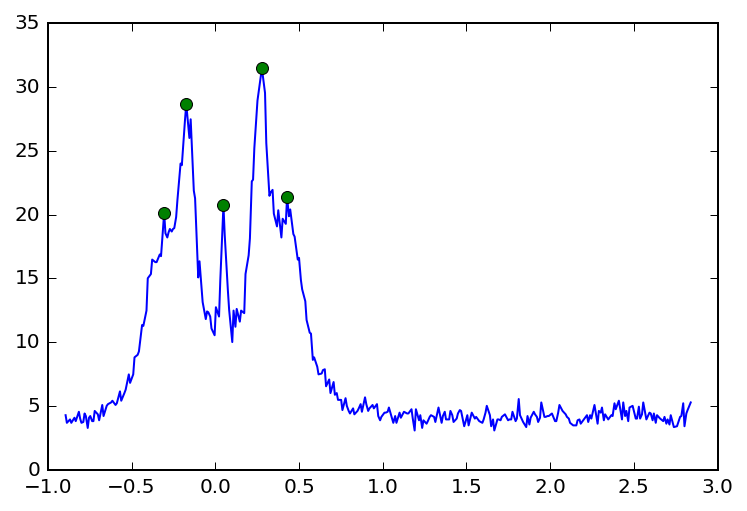

In [47]:
Q, I = l_prof_max('e16018','104',L=4.06637,q=True)
idxs = pk.indexes(I, thres=0.5, min_dist=10)
peaks = I[idxs].argsort()[::1][:]
xpeak, ypeak = Q[idxs][peaks], I[idxs][peaks]
plt.plot(Q,I)
plt.plot(xpeak, ypeak, 'o');

Try and determine background as something below a certain intrensity (in this case, 5)

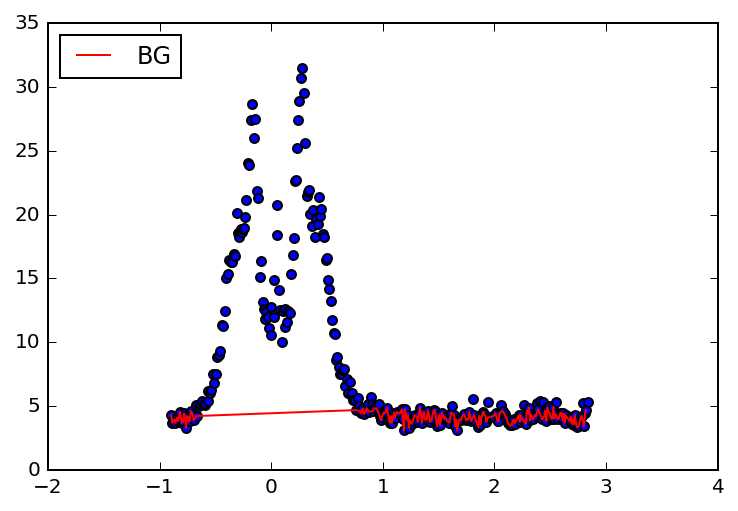

In [48]:
plt.plot(Q[I<5],I[I<5], 'red', label='BG')
plt.scatter(Q,I)
plt.legend(loc='upper left')
xbg = Q[I<5]
ybg = I[I<5]

Fit such background with a polynomial:

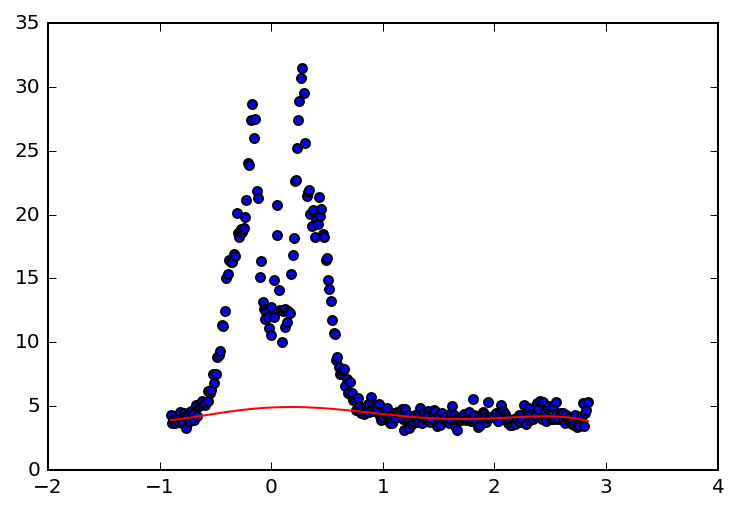

In [49]:
pfit = np.polyfit(xbg, ybg, 5)
bg = np.polyval(pfit, Q)
plt.scatter(Q,I)
plt.plot(Q,bg,'red')

And subtract it from the data:

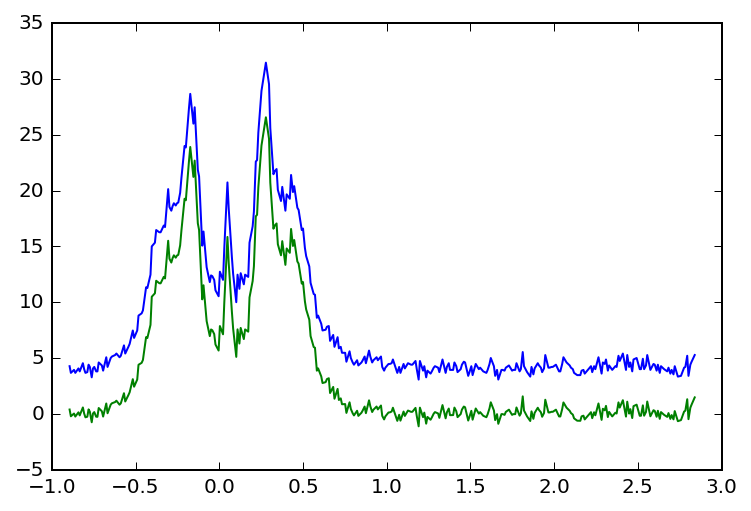

In [50]:
i_corr = I - bg
plt.plot(Q,I,Q,i_corr);

Select the range of data that is to be fitted:

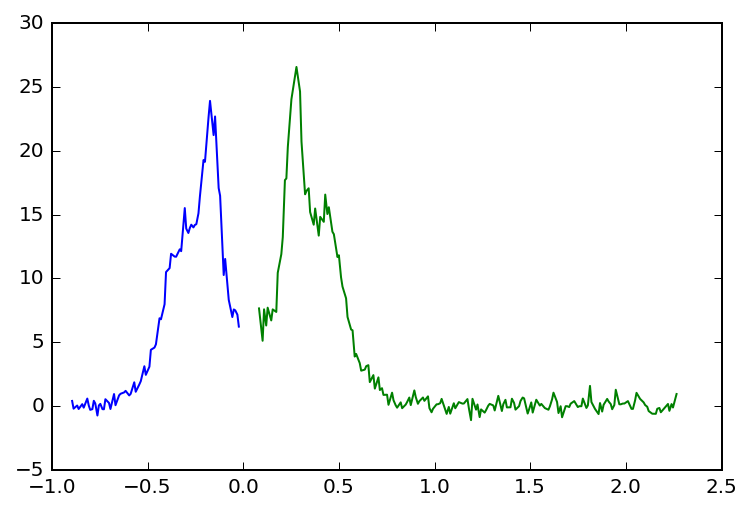

In [51]:
dist = 0.3
dist2 = 0.35
bg_dist = 1.5


# first set of peaks
idx_1 = (Q > xpeak[0] - dist - bg_dist) & (Q < xpeak[0] + dist)
q1, i1 = Q[idx_1], i_corr[idx_1]

# second set of peaks
idx_2 = (Q > xpeak[2] - dist2) & (Q < xpeak[2] + dist2 + bg_dist)
q2, i2 = Q[idx_2], i_corr[idx_2]

plt.plot(q1,i1,q2,i2);

Select a set of initial parameters to estimate the lorentzians for each set of peaks.
##### Set 1

Initial parameteres:

In [52]:
# initial values:
p11 = [0.1,-0.5,10] # fwhm, peak centre, intensity
p12 = [0.01,-0.15,25]

Refine parameters via least-squares using the residuals function:

In [53]:
pbest11 = leastsq(res, p11, args=(p12, i1, q1), full_output=1)
pb11 = pbest11[0]
pbest12 = leastsq(res, p12, args=(pb11, i1, q1), full_output=1)
pb12 = pbest12[0]

Calculate the lorentzians with these parameters and plot it:

The FWHM1 is: 0.151; the FWHM2 is 0.030


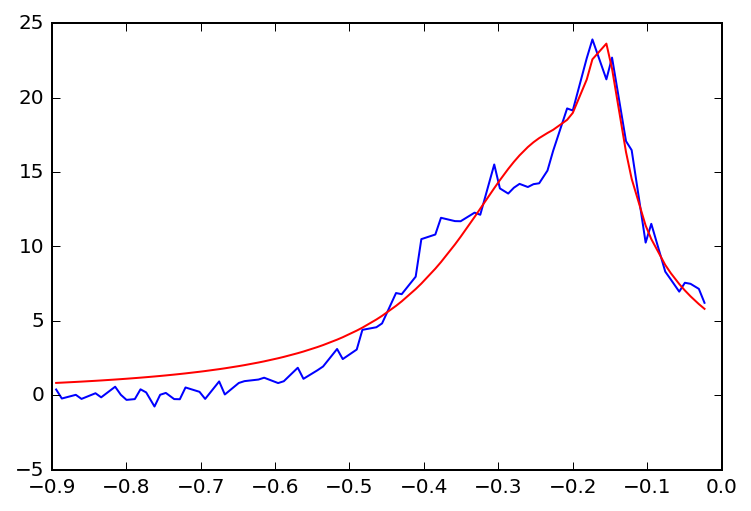

In [54]:
fit1 = lor_sum(q1,pb11,pb12)
plt.plot(q1,i1)
plt.plot(q1,fit1,'red');
print('The FWHM1 is: {0:.3f}; the FWHM2 is {1:.3f}'.format(pb11[0],pb12[0]))

##### Set 2

[-0.3054554   0.04866483  0.42873597 -0.17350931  0.27827904]
[ 20.13333333  20.73333333  21.4         28.66666667  31.46666667]


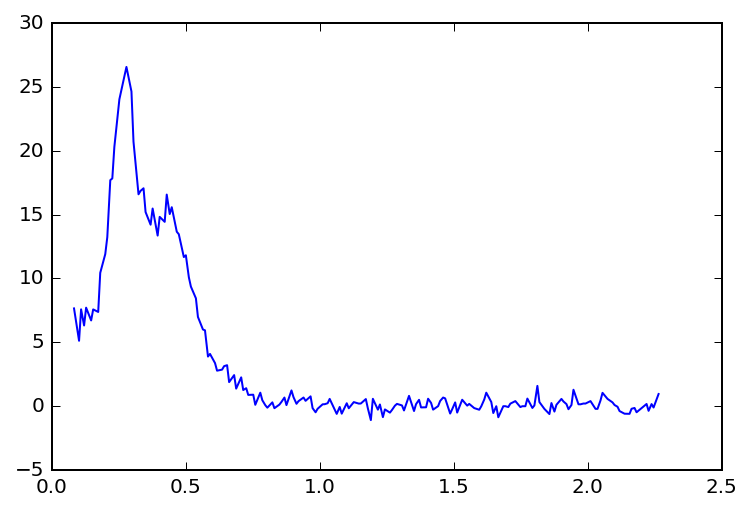

In [55]:
plt.plot(q2,i2);
print xpeak
print ypeak

Initial parameteres:

In [56]:
# initial values:
p21 = [0.1,0.27,25] # fwhm, peak centre, intensity
p22 = [0.5,1,15]

Refine parameters via least-squares using the residuals function:

In [57]:
pbest21 = leastsq(res, p21, args=(p22, i2, q2), full_output=1)
pb21 = pbest21[0]
pbest22 = leastsq(res, p22, args=(pb21, i2, q2), full_output=1)
pb22 = pbest22[0]

Calculate the lorentzians with these parameters and plot it:

The FWHM1 is: 0.056; the FWHM2 is 0.114


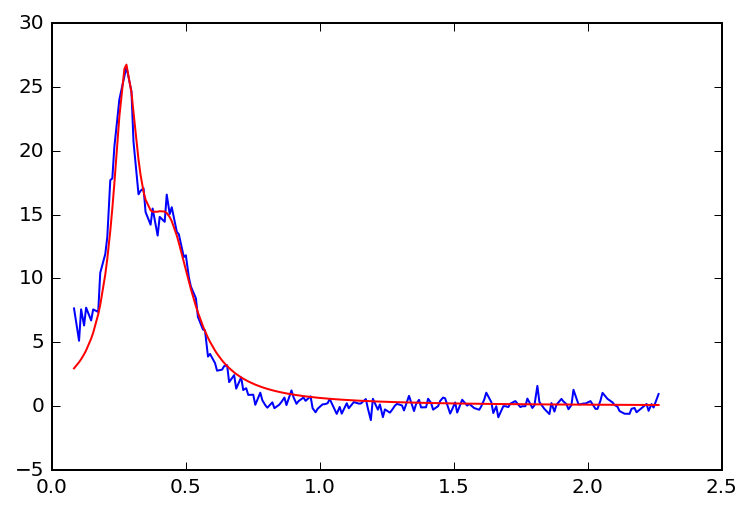

In [58]:
fit2 = lor_sum(q2,pb21,pb22)
plt.plot(q2,i2)
plt.plot(q2,fit2,'red');
print('The FWHM1 is: {0:.3f}; the FWHM2 is {1:.3f}'.format(pb21[0],pb22[0]))

### Plot the whole thing:

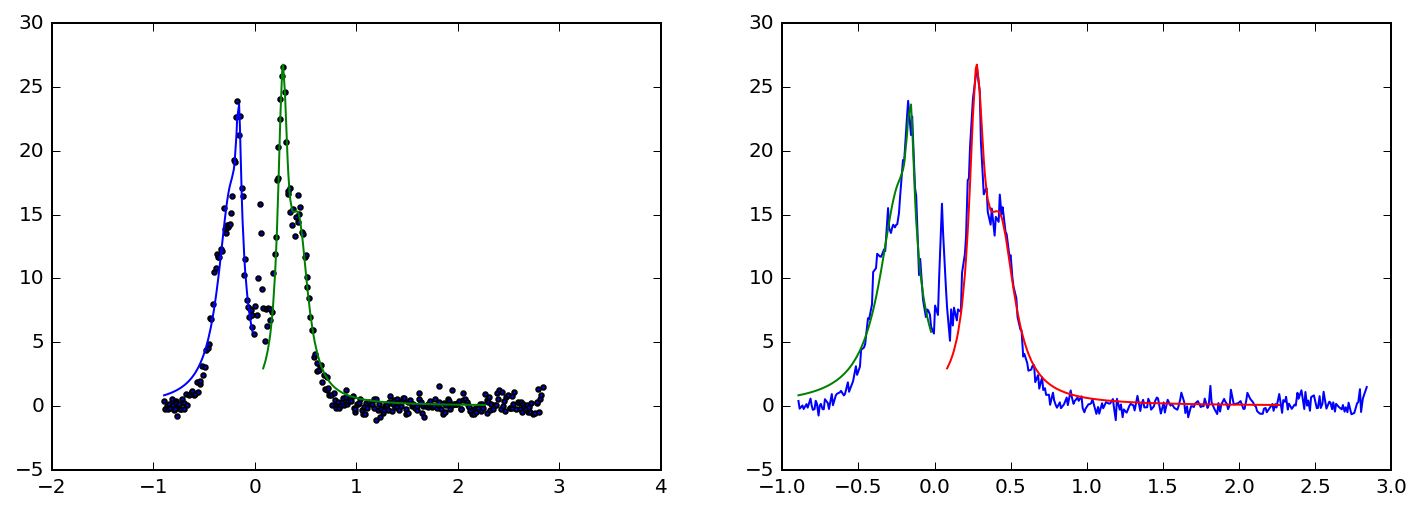

In [59]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(Q,i_corr,marker='.')
ax[0].plot(q1,fit1,q2,fit2)
ax[1].plot(Q,i_corr)
ax[1].plot(q1,fit1,q2,fit2)
plt.show()

Add the data to the graph once more

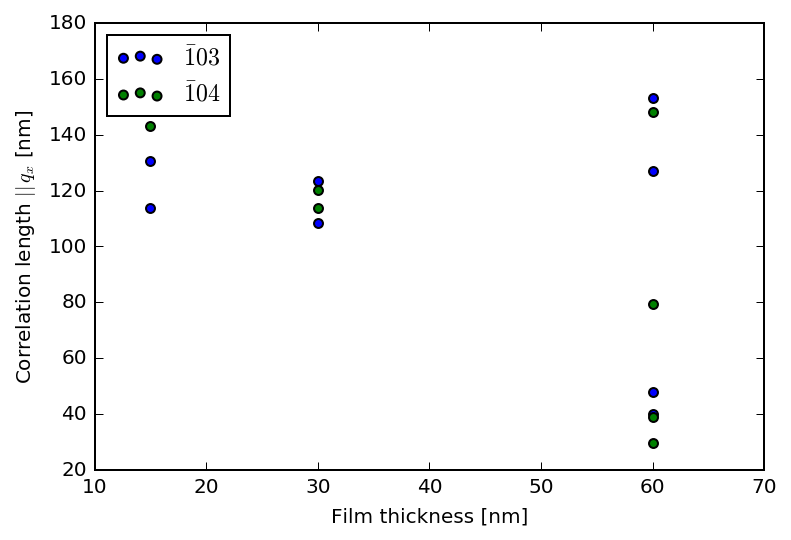

In [110]:
x = [15,15,30,30,60,60,60,60]
x2 = [15,15,30,30,60,60,60,60]
y = [0.034,0.039,0.036,0.041,0.111,0.035,0.029,0.093]
for index in range(len(y)):
    y[index] = y[index]*np.sqrt(2)
    y[index] = (2*np.pi)/y[index]
y2 = [0.026,0.031,0.037,0.039,0.056,0.114,0.030,0.151]
for index in range(len(y2)):
    y2[index] = y2[index]*np.sqrt(2)
    y2[index] = (2*np.pi)/y2[index]
plt.scatter(x,y,label=r'$\bar{1}03$')
plt.scatter(x2,y2,c='green',label=r'$\bar{1}04$')
plt.xlabel('Film thickness [nm]')
plt.ylabel(r'Correlation length $|| \, q_x$ [nm]')
plt.legend(loc='upper left');